In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from qutip import *
import matplotlib
from tqdm import tqdm
import json

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)


from slab.datamanagement import SlabFile
from slab.dataanalysis import get_next_filename
from slab.experiments.PulseExperiments_PXI.PostExperimentAnalysis import PostExperiment
from slab.experiments.PulseExperiments_PXI.sequences_pxi import PulseSequences
from slab.dsfit import*

In [54]:
multimode_params = {"Ej":21,"Ec":0.13,"N":100,"nus":[8.07,6.015],"gs":[0.177,0.067],"T1s":[50e3,300,1e6],"nths":[0.1,0.01,0.1],"truncation":[3,3,3],"amp_cal":[0.1,1.0]}

In [83]:
class Simulate_Multimode_Experiment:
    
    def __init__(self, quantum_device_cfg, experiment_cfg, hardware_cfg,multimode_params = None,RWA = False,dtsim = 1.0,sequences=None, name=None):
        
        self.quantum_device_cfg = quantum_device_cfg
        self.experiment_cfg = experiment_cfg
        self.hardware_cfg = hardware_cfg
        self.params = multimode_params
        self.dtsim = dtsim

        self.I = None
        self.Q = None
        
        self.JC_hamiltonian(RWA)


    def transmon_hamiltonian(self,ng):
        
        Ej,Ec,N = self.params["Ej"],self.params["Ec"],self.params["N"]
        m = np.diag(4*Ec*(arange(-N,N+1) - ng)**2) -  Ej/2.0*((np.diag(np.ones(2*N), -1) + np.diag(np.ones(2*N), 1)))
        
        return Qobj(m)
    

    def plot_transmon_energies(self,ng_vec,ylim=(0, 10)):
        
        energies = array([self.transmon_hamiltonian(ng).eigenstates()[0] for ng in ng_vec])
        print ("Qubit frequency = %s"%(energies.T[1][0]-energies.T[0][0]))
        fig, axes = plt.subplots(1,1, figsize=(12,5))

        for n in range(len(energies[0,:])):
            axes.plot(ng_vec, (energies[:,n]-energies[:,0]))
        axes.set_ylim(ylim[0], ylim[1])
        axes.set_xlim(ng_vec[0], ng_vec[-1])
        axes.set_xlabel(r'$n_g$', fontsize=18)
        axes.set_ylabel(r'$E_n$', fontsize=18)
        
        return fig, axes
    
    def JC_hamiltonian(self,RWA = False):
        
        N_q,N_r,N_m = self.params["truncation"]
        omega_r,omega_m = 2*pi*array(self.params["nus"])
        omega_gr,omega_gm = 2*pi*array(self.params["gs"])
        
        
        energies = self.transmon_hamiltonian(0).eigenstates()[0] # energies in GHz
        omega_q = 2*pi*Qobj(diag(energies[0:N_q]-energies[0])) # converting to angular frequency

        self.ar = tensor(destroy(N_r),qeye(N_m),qeye(N_q))
        self.am = tensor(qeye(N_r),destroy(N_m),qeye(N_q))
        self.b = tensor(qeye(N_r),qeye(N_m),destroy(N_q))

        if RWA:
            self.H = omega_r*self.ar.dag()*self.ar + omega_m*self.am.dag()*self.am  + tensor(qeye(N_r),qeye(N_m),omega_q) + omega_gr*(self.ar.dag()*self.b + self.ar*self.b.dag()) +omega_gm*(self.am.dag()*self.b + self.am*self.b.dag()) 
        else:
            self.H = omega_r*self.ar.dag()*self.ar + omega_m*self.am.dag()*self.am   +    tensor(qeye(N_r),qeye(N_m),omega_q) + omega_gr*(self.ar.dag() + self.ar)*(self.b.dag()+self.b) + omega_gm*(self.am.dag() + self.am)*(self.b.dag()+self.b) 

        self.jc_energies,self.jc_vectors = self.H.eigenstates()[0],self.H.eigenstates()[1]
        self.nr_vec = array([expect(self.ar.dag()*self.ar, jc_vector) for jc_vector in self.jc_vectors])
        self.nm_vec = array([expect(self.am.dag()*self.am, jc_vector) for jc_vector in self.jc_vectors])
        self.nq_vec = array([expect(self.b.dag()*self.b, jc_vector) for jc_vector in self.jc_vectors])
            
        return self.H
    
    def JC_spectrum_states(self):
        
        level_number = arange(len(self.jc_energies)) + 1
        fig = plt.figure(figsize = (12,5))
        ax = fig.add_subplot(111)
        ax.plot(level_number,self.jc_energies/(2*pi),'k.--',markersize=10)
        ax.set_xlabel('Level number')
        ax.set_ylabel('Frequency (GHz)')
        ax2 = ax.twinx()
        ax2.plot(level_number,self.nr_vec,'rs',label ='$n_{r}$',alpha=0.5)
        ax2.plot(level_number,self.nm_vec,'gs',label ='$n_{m}$',alpha=0.5)
        ax2.plot(level_number,self.nq_vec,'bd',label ='$n_{q}$',alpha=0.5)
        ax2.set_yticks(arange(5))
        ax2.set_ylabel('$n_{r,q}$', color='k')
        ax2.tick_params('y', colors='k')
        ax2.legend()
        print ("|q r>")
        for ii in arange(len(level_number)):
            print ("|%s,%s,%s> : %s GHz"%(int(round(self.nq_vec[ii])),int(round(self.nr_vec[ii])),int(round(self.nm_vec[ii])),around(self.jc_energies[ii]/(2*pi),10)))
    
    def find_freq(self,nq, nr, nm):
        return self.jc_energies[argmin(abs(self.nr_vec-nr) +abs(self.nm_vec-nm)+ abs(self.nq_vec-nq))]/(2*pi)

    def projector(self,nq, nr, nm):
        ind = argmin(abs(self.nr_vec-nr) +abs(self.nm_vec-nm)+ abs(self.nq_vec-nq))
        return self.jc_vectors[ind]*self.jc_vectors[ind].dag()

    def state(self,nq, nr, nm):
        ind = argmin(abs(self.nr_vec-nr) +abs(self.nm_vec-nm)+ abs(self.nq_vec-nq))
        return self.jc_vectors[ind]

    def Udress(self):
        N_q,N_r,N_m = self.params["truncation"]
        op = 0
        
        for ii, nq in enumerate(self.nq_vec):
            nq_r = int(round(nq))
            nr_r = int(round(self.nr_vec[ii]))
            nm_r = int(round(self.nm_vec[ii]))
            op += self.jc_vectors[ii]*tensor(basis(N_r,nr_r),basis(N_m,nm_r),basis(N_q,nq_r)).dag()

        return op  
    
    def lindblad_dissipator(self):
        
        kappa_q,kappa_r,kappa_m = 1/(array(self.params["T1s"]))
        n_thq,n_thr,n_thm = self.params["nths"]

        c_ops = kappa_q*(1+n_thq)*lindblad_dissipator(self.b) + kappa_q*(n_thq)*lindblad_dissipator(self.b.dag())+kappa_r*(1+n_thr)*lindblad_dissipator(self.ar) + kappa_r*(n_thr)*lindblad_dissipator(self.ar.dag())\
        + kappa_m*(1+n_thm)*lindblad_dissipator(self.am) + kappa_m*(n_thm)*lindblad_dissipator(self.am.dag())
        
        return c_ops
    
    
    def H_t(self):
        
        def Hd_coeff(t, args):
            xi = args['xi']
            nud = args['nud']
            return 2*pi*xi*sin((2*pi*nud)*t)
        
        Hd = (self.ar + self.ar.dag())
        return [self.H, [Hd, Hd_coeff]]
 
    def rabisquaremesolve(self,tlist = np.linspace(0,300.0,601),xi=0.1,psi0=None,nu_d = 0):

        print ("Drive frequency - %s GHz"%(nu_d))
        print ("Drive amplitude - %s GHz"%(xi))
        
        c_ops = self.lindblad_dissipator()
        
        ard = self.ar.transform(self.Udress())
        amd = self.am.transform(self.Udress())
        bd =  self.b.transform(self.Udress())
        
        output = mesolve(self.H_t(), psi0, tlist, c_ops, [ard.dag()*ard,amd.dag()*amd,bd.dag()*bd],args={'xi': xi, 'nud': nu_d},progress_bar=True, options = Odeoptions(nsteps =12000) )

        return output
    
    def sequenceslist(self,sequences,waveform_channels):
        wv = []
        for channel in waveform_channels:
            if not channel == None:
                wv.append(sequences[channel])
            else:
                wv.append(np.zeros_like(sequences[waveform_channels[0]]))
        return wv
    
    def get_qubit_iq_waveforms(self, name, sequences):
        
        pxi_waveform_channels = self.hardware_cfg['awg_info']['keysight_pxi']['waveform_channels']
        pxi_sequences = {}
        for channel in pxi_waveform_channels:
            pxi_sequences[channel] = sequences[channel]
        wv = self.sequenceslist(pxi_sequences,pxi_waveform_channels)
        return wv

    def get_sideband_waveforms(self, name,sequences):
        
        if 'sideband' in name:
            tek2_waveform_channels = self.hardware_cfg['awg_info']['tek70001a']['waveform_channels']
            tek2_waveforms = [sequences[channel] for channel in tek2_waveform_channels]
            return tek2_waveforms
        else:pass
        
    def get_charge_pulse(self,name,sequences):
        amps = self.params['amp_cal']
        
        nu = self.quantum_device_cfg['qubit']['1']['freq'] - self.quantum_device_cfg['pulse_info']['1']['iq_freq']
        readout = int((self.quantum_device_cfg['readout']['length']+175)/self.dtsim)
        pad = int(590/self.dtsim)
        cut = int(1500/self.dtsim)
        tek2_delay = int(self.hardware_cfg['channels_delay']['tek2_trig']/self.dtsim)
       
        
        I,Q = amps[0]*(array(self.get_qubit_iq_waveforms(name,sequences)).T[pad-tek2_delay:-readout]).T[:2]
        t = arange(len(I.T))*self.dtsim
        R = [i*cos(2*pi*nu*t)+Q[ii]*sin(2*pi*nu*t) for ii,i in enumerate(I)]
        
        if 'sideband' in name: 
            SB = self.get_sideband_waveforms(name,sequences)[0]
            tr = array(self.get_qubit_iq_waveforms(name,sequences))[4]
            for ii,y in enumerate(tr):tr[ii][cut:cut+len(SB[0])] = SB[ii]
            tr = tr.T[pad-tek2_delay:-readout].T
            R = [r + amps[1]*array(tr[ii]) for ii,r in enumerate(R)]
            
        return t,array(R)
        
    def psb_mesolve(self,name,sequences,seq_list = None):

        Hd = (self.ar + self.ar.dag())
        psi0 = self.state(0,0,0)
        c_ops = self.lindblad_dissipator()
        

        tlist,cp = self.get_charge_pulse(name,sequences)
        
        if seq_list is None:seq_list = arange(len(cp))

        def make_cp_func(seq_num):
            def _function(t,args=None):
                time_id = int(t/self.dtsim)
                if time_id >= len(cp[seq_num]): return 0
                else:return 2*pi*cp[seq_num][time_id]
            return _function
        
        output = []
        for ii in tqdm(seq_list):
            H_t= [self.H, [Hd, make_cp_func(ii)]]
            output.append(mesolve(H_t, psi0, tlist, c_ops, [self.projector(1,0,0)],progress_bar=True, options = Odeoptions(nsteps =12000)))
                          
        return output        
        
    
    def post_analysis(self,experiment_name,P='Q',show = False,check_sync = False):
        if check_sync:pass
        else:PA = PostExperiment(self.quantum_device_cfg, self.experiment_cfg, self.hardware_cfg, experiment_name, self.I ,self.Q, P,show)

In [84]:
with open('quantum_device_config.json', 'r') as f:
    quantum_device_cfg  = json.load(f)
with open('experiment_config.json', 'r') as f:
    experiment_cfg = json.load(f)
with open('hardware_config.json', 'r') as f:
    hardware_cfg = json.load(f)

dtsim = 0.05
hardware_cfg['awg_info']['keysight_pxi']['dt'] = dtsim
hardware_cfg['awg_info']['tek70001a']['dt'] = dtsim
quantum_device_cfg['qubit']['1']['frequency'] = 4.527556074037375
quantum_device_cfg['pulse_info']['1']['iq_freq'] = 0.2
quantum_device_cfg['pulse_info']['1']['pulse_type'] = 'gauss'


experiment_names = ['rabi']

for experiment_name in experiment_names:
    ps = PulseSequences(quantum_device_cfg , experiment_cfg, hardware_cfg,plot_visdom=False)
    sequences = ps.get_experiment_sequences(experiment_name)
    s = Simulate_Multimode_Experiment(quantum_device_cfg , experiment_cfg, hardware_cfg,multimode_params,True,dtsim,sequences, experiment_name)


Qubit frequency = 4.539417897330027
|q r>
|0,0,0> : 0.0 GHz
|1,0,0> : 4.527556074 GHz
|0,0,1> : 6.0180049777 GHz
|0,1,0> : 8.0788568456 GHz
|2,0,0> : 8.9169414174 GHz
|1,0,1> : 10.545051171 GHz
|0,0,2> : 12.0360094183 GHz
|1,1,0> : 12.6057460868 GHz
|0,1,1> : 14.096860464 GHz
|2,0,1> : 14.9264679827 GHz
|0,2,0> : 16.1577128387 GHz
|1,0,2> : 16.5715189165 GHz
|2,1,0> : 16.9702826691 GHz
|1,1,1> : 18.6231230909 GHz
|0,1,2> : 20.114847131 GHz
|1,2,0> : 20.7101768856 GHz
|2,0,2> : 20.9524104356 GHz
|0,2,1> : 22.1758082191 GHz
|2,1,1> : 22.9799269995 GHz
|1,1,2> : 24.6494566246 GHz
|2,2,0> : 25.0741386118 GHz
|1,2,1> : 26.7274897731 GHz
|0,2,2> : 28.1938701544 GHz
|2,1,2> : 29.0055728681 GHz
|2,2,1> : 31.0838410688 GHz
|1,2,2> : 32.7539751634 GHz
|2,2,2> : 37.1094856015 GHz


C:\Users\slab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


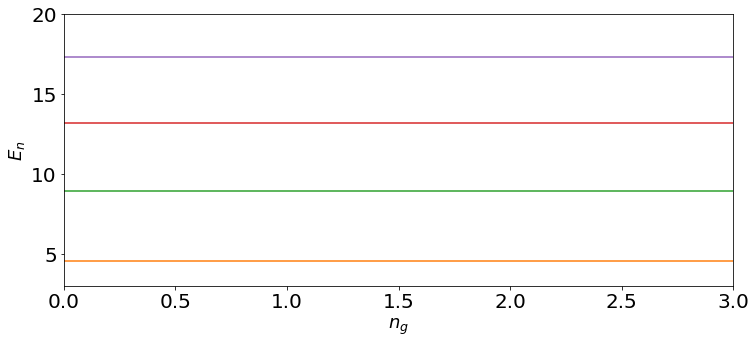

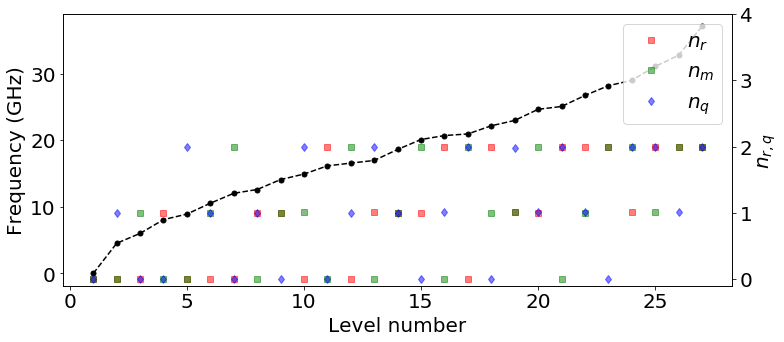

In [74]:
ng_vec = np.linspace(0,3,100)
s.plot_transmon_energies(ng_vec,ylim=(3,20))
s.JC_spectrum_states()

In [9]:
output = s.rabisquaremesolve(tlist = np.linspace(0,300.0,101),xi=0.1,psi0=s.state(1,0,0),nu_d = s.find_freq(1,0,0)-s.find_freq(0,0,0))

Drive frequency - 4.527556074037375 GHz
Drive amplitude - 0.1 GHz
10.9%. Run time:   1.61s. Est. time left: 00:00:00:13
20.8%. Run time:   3.08s. Est. time left: 00:00:00:11
30.7%. Run time:   4.55s. Est. time left: 00:00:00:10
40.6%. Run time:   6.03s. Est. time left: 00:00:00:08
50.5%. Run time:   7.50s. Est. time left: 00:00:00:07
60.4%. Run time:   8.99s. Est. time left: 00:00:00:05
70.3%. Run time:  10.46s. Est. time left: 00:00:00:04
80.2%. Run time:  11.93s. Est. time left: 00:00:00:02
90.1%. Run time:  13.39s. Est. time left: 00:00:00:01
Total run time:  14.72s


Rabi frequency = 9.966723406738957 MHz 
Rabi decay time = 37.92919745970334 mus


C:\Users\slab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


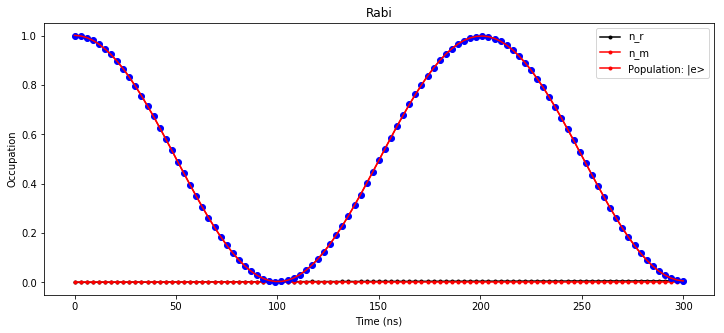

In [11]:
n_r = []
n_m = []
n_q = []
tlist_all = []
tlist = np.linspace(0,300.0,101)

n_r.append(output.expect[0])
n_m.append(output.expect[1])
n_q.append(output.expect[2])
tlist_all.append(tlist) 

for ii in range(len(n_r)):
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111,title='Rabi')
    ax.plot(tlist_all[ii], n_r[ii],'k.-', label="n_r")
    ax.plot(tlist_all[ii], n_m[ii],'r.-', label="n_m")
    ax.plot(tlist_all[ii], n_q[ii],'r.-', label="Population: |e>")
    ax.legend()
    fits = fitdecaysin(tlist_all[ii][:], n_q[ii][:],showfit=True)
    
    print ("Rabi frequency = %s MHz "%(2*fits[1]*1e3))
    print ("Rabi decay time = %s mus"%(fits[3]/1e3))
    ax.set_ylabel('Occupation')
    ax.set_xlabel('Time (ns)')
    # ax.set_xlim(0,800)



In [187]:
tlist = np.linspace(0,2000.0,1001)
psi0 = s.state(2,0,0)
nu_d = s.find_freq(2,0,0)-s.find_freq(0,0,1)
xi = 1.0
output = s.rabisquaremesolve(tlist,xi,psi0,nu_d)

Drive frequency - 2.89893643968355 GHz
Drive amplitude - 1.0 GHz
10.1%. Run time:   8.48s. Est. time left: 00:00:01:15
20.1%. Run time:  16.84s. Est. time left: 00:00:01:07
30.1%. Run time:  25.18s. Est. time left: 00:00:00:58
40.1%. Run time:  33.51s. Est. time left: 00:00:00:50
50.0%. Run time:  41.88s. Est. time left: 00:00:00:41
60.0%. Run time:  50.22s. Est. time left: 00:00:00:33
70.0%. Run time:  58.60s. Est. time left: 00:00:00:25
80.0%. Run time:  66.94s. Est. time left: 00:00:00:16
90.0%. Run time:  75.32s. Est. time left: 00:00:00:08
Total run time:  83.60s


Rabi frequency = 1.4741905912415574 MHz 
Rabi decay time = 1.3195551679666793 mus


C:\Users\slab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


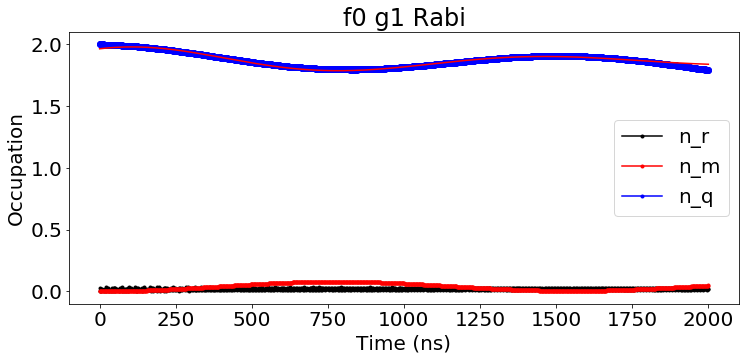

In [191]:
n_r = []
n_m = []
n_q = []
tlist_all = []

n_r.append(output.expect[0])
n_m.append(output.expect[1])
n_q.append(output.expect[2])
tlist_all.append(tlist) 

for ii in range(len(n_r)):
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111,title='f0 g1 Rabi')
    ax.plot(tlist_all[ii], n_r[ii],'k.-', label="n_r")
    ax.plot(tlist_all[ii], n_m[ii],'r.-', label="n_m")
    ax.plot(tlist_all[ii], n_q[ii],'b.-', label="n_q")
    ax.legend()
    fits = fitdecaysin(tlist_all[ii][:], n_q[ii][:],showfit=True)
    
    print ("Rabi frequency = %s MHz "%(2*fits[1]*1e3))
    print ("Rabi decay time = %s mus"%(fits[3]/1e3))
    ax.set_ylabel('Occupation')
    ax.set_xlabel('Time (ns)')
    # ax.set_xlim(0,800)



In [200]:
tlist = np.linspace(0,3000.0,501)
psi0 = s.state(2,0,0)
nu_d = s.find_freq(2,0,0)-s.find_freq(0,0,1)
xi = 1.2

det = 5e-3
detlist = linspace(0,det,10)

output_g1_f0 = []
for df in tqdm(detlist):
    output_g1_f0.append(mesolve(s.H_t(), psi0, tlist, c_ops, [s.projector(0, 0, 1),s.projector(2, 0, 0)],args={'xi': xi, 'nud': nu_d + df},progress_bar= True, options = Odeoptions(nsteps =12000) ))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

10.2%. Run time:  13.33s. Est. time left: 00:00:01:57
20.2%. Run time:  26.31s. Est. time left: 00:00:01:44
30.1%. Run time:  39.26s. Est. time left: 00:00:01:30
40.1%. Run time:  52.17s. Est. time left: 00:00:01:17
50.1%. Run time:  65.11s. Est. time left: 00:00:01:04
60.1%. Run time:  78.04s. Est. time left: 00:00:00:51
70.1%. Run time:  90.97s. Est. time left: 00:00:00:38
80.0%. Run time: 103.92s. Est. time left: 00:00:00:25
90.0%. Run time: 116.83s. Est. time left: 00:00:00:12
Total run time: 129.49s


 10%|████████▏                                                                         | 1/10 [02:09<19:25, 129.50s/it]

10.2%. Run time:  13.13s. Est. time left: 00:00:01:55
20.2%. Run time:  26.10s. Est. time left: 00:00:01:43
30.1%. Run time:  39.01s. Est. time left: 00:00:01:30
40.1%. Run time:  51.91s. Est. time left: 00:00:01:17
50.1%. Run time:  64.84s. Est. time left: 00:00:01:04
60.1%. Run time:  77.75s. Est. time left: 00:00:00:51
70.1%. Run time:  90.66s. Est. time left: 00:00:00:38
80.0%. Run time: 103.56s. Est. time left: 00:00:00:25
90.0%. Run time: 116.48s. Est. time left: 00:00:00:12
Total run time: 129.14s


 20%|████████████████▍                                                                 | 2/10 [04:18<17:15, 129.39s/it]

10.2%. Run time:  13.23s. Est. time left: 00:00:01:56
20.2%. Run time:  26.17s. Est. time left: 00:00:01:43
30.1%. Run time:  39.10s. Est. time left: 00:00:01:30
40.1%. Run time:  52.05s. Est. time left: 00:00:01:17
50.1%. Run time:  65.00s. Est. time left: 00:00:01:04
60.1%. Run time:  77.93s. Est. time left: 00:00:00:51
70.1%. Run time:  90.85s. Est. time left: 00:00:00:38
80.0%. Run time: 103.79s. Est. time left: 00:00:00:25
90.0%. Run time: 116.72s. Est. time left: 00:00:00:12
Total run time: 129.41s


 30%|████████████████████████▌                                                         | 3/10 [06:28<15:05, 129.40s/it]

10.2%. Run time:  13.18s. Est. time left: 00:00:01:56
20.2%. Run time:  26.09s. Est. time left: 00:00:01:43
30.1%. Run time:  39.02s. Est. time left: 00:00:01:30
40.1%. Run time:  51.97s. Est. time left: 00:00:01:17
50.1%. Run time:  64.89s. Est. time left: 00:00:01:04
60.1%. Run time:  77.82s. Est. time left: 00:00:00:51
70.1%. Run time:  90.75s. Est. time left: 00:00:00:38
80.0%. Run time: 103.65s. Est. time left: 00:00:00:25
90.0%. Run time: 116.56s. Est. time left: 00:00:00:12
Total run time: 129.28s


 40%|████████████████████████████████▊                                                 | 4/10 [08:37<12:56, 129.36s/it]

10.2%. Run time:  13.56s. Est. time left: 00:00:01:59
20.2%. Run time:  26.52s. Est. time left: 00:00:01:45
30.1%. Run time:  39.43s. Est. time left: 00:00:01:31
40.1%. Run time:  52.32s. Est. time left: 00:00:01:18
50.1%. Run time:  65.22s. Est. time left: 00:00:01:04
60.1%. Run time:  78.12s. Est. time left: 00:00:00:51
70.1%. Run time:  91.00s. Est. time left: 00:00:00:38
80.0%. Run time: 103.90s. Est. time left: 00:00:00:25
90.0%. Run time: 116.85s. Est. time left: 00:00:00:12
Total run time: 129.52s


 50%|█████████████████████████████████████████                                         | 5/10 [10:46<10:47, 129.41s/it]

10.2%. Run time:  13.15s. Est. time left: 00:00:01:56
20.2%. Run time:  26.10s. Est. time left: 00:00:01:43
30.1%. Run time:  39.02s. Est. time left: 00:00:01:30
40.1%. Run time:  51.94s. Est. time left: 00:00:01:17
50.1%. Run time:  64.82s. Est. time left: 00:00:01:04
60.1%. Run time:  77.72s. Est. time left: 00:00:00:51
70.1%. Run time:  90.60s. Est. time left: 00:00:00:38
80.0%. Run time: 103.53s. Est. time left: 00:00:00:25
90.0%. Run time: 116.43s. Est. time left: 00:00:00:12
Total run time: 129.05s


 60%|█████████████████████████████████████████████████▏                                | 6/10 [12:55<08:37, 129.30s/it]

10.2%. Run time:  13.11s. Est. time left: 00:00:01:55
20.2%. Run time:  25.99s. Est. time left: 00:00:01:42
30.1%. Run time:  38.84s. Est. time left: 00:00:01:30
40.1%. Run time:  51.71s. Est. time left: 00:00:01:17
50.1%. Run time:  64.57s. Est. time left: 00:00:01:04
60.1%. Run time:  77.42s. Est. time left: 00:00:00:51
70.1%. Run time:  90.29s. Est. time left: 00:00:00:38
80.0%. Run time: 103.14s. Est. time left: 00:00:00:25
90.0%. Run time: 115.98s. Est. time left: 00:00:00:12
Total run time: 128.54s


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [15:04<06:27, 129.08s/it]

10.2%. Run time:  13.13s. Est. time left: 00:00:01:55
20.2%. Run time:  26.01s. Est. time left: 00:00:01:43
30.1%. Run time:  38.86s. Est. time left: 00:00:01:30
40.1%. Run time:  51.75s. Est. time left: 00:00:01:17
50.1%. Run time:  64.63s. Est. time left: 00:00:01:04
60.1%. Run time:  77.51s. Est. time left: 00:00:00:51
70.1%. Run time:  90.45s. Est. time left: 00:00:00:38
80.0%. Run time: 103.34s. Est. time left: 00:00:00:25
90.0%. Run time: 116.22s. Est. time left: 00:00:00:12
Total run time: 128.84s


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [17:13<04:18, 129.01s/it]

10.2%. Run time:  13.12s. Est. time left: 00:00:01:55
20.2%. Run time:  26.02s. Est. time left: 00:00:01:43
30.1%. Run time:  38.90s. Est. time left: 00:00:01:30
40.1%. Run time:  51.79s. Est. time left: 00:00:01:17
50.1%. Run time:  64.63s. Est. time left: 00:00:01:04
60.1%. Run time:  77.51s. Est. time left: 00:00:00:51
70.1%. Run time:  90.40s. Est. time left: 00:00:00:38
80.0%. Run time: 103.27s. Est. time left: 00:00:00:25
90.0%. Run time: 116.15s. Est. time left: 00:00:00:12
Total run time: 128.78s


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [19:22<02:08, 128.94s/it]

10.2%. Run time:  13.10s. Est. time left: 00:00:01:55
20.2%. Run time:  25.95s. Est. time left: 00:00:01:42
30.1%. Run time:  38.81s. Est. time left: 00:00:01:29
40.1%. Run time:  51.68s. Est. time left: 00:00:01:17
50.1%. Run time:  64.59s. Est. time left: 00:00:01:04
60.1%. Run time:  77.49s. Est. time left: 00:00:00:51
70.1%. Run time:  90.37s. Est. time left: 00:00:00:38
80.0%. Run time: 103.25s. Est. time left: 00:00:00:25
90.0%. Run time: 116.12s. Est. time left: 00:00:00:12
Total run time: 128.71s


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [21:30<00:00, 128.87s/it]


Rabi frequency = 3.030567236819062 MHz 
t_pi = %s MHz  329.9712304187707 ns
Rabi decay time = -178.08582500541004 mus


Text(0.5,0,'Time (ns)')

C:\Users\slab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


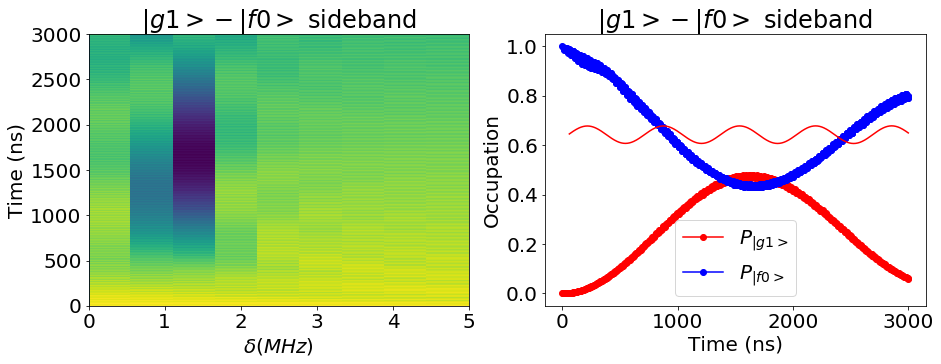

In [205]:
n_g1 = []
n_f0 = []

ind =  2
for ii,sol in enumerate(output_g1_f0):

    n_g1.append(sol.expect[0])
    n_f0.append(sol.expect[1])
    
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121,title='$|g1> - |f0>$ sideband')
ax.pcolormesh(detlist*1e3,tlist,array(n_f0).T)
ax.set_xlabel('$\\delta (MHz)$')
ax.set_ylabel('Time (ns)')
ax.axvline(detlist[ind])

ax = fig.add_subplot(122,title='$|g1> - |f0>$ sideband')
ax.plot(tlist, n_g1[ind],'ro-', label="$P_{|g1>}$")
ax.plot(tlist, n_f0[ind],'bo-', label="$P_{|f0>}$")
ax.legend()

fits= fitdecaysin(tlist[10:], n_f0[ind][10:],showfit=True)
print ("Rabi frequency = %s MHz "%(2*fits[1]*1e3))
print ("t_pi = %s MHz ",(1/fits[1]/2.0),"ns")
print ("Rabi decay time = %s mus"%(fits[3]/1e3))
ax.set_ylabel('Occupation')
ax.set_xlabel('Time (ns)')


In [113]:
w = array(s.get_sideband_waveforms(experiment_name,sequences))
x = array(s.get_qubit_iq_waveforms(experiment_name,sequences))
for ii,y in enumerate(x[4]):x[4][ii][int(1500/dtsim):int(1500/dtsim)+len(w[0][0])] = w[0][ii]

C:\Users\slab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


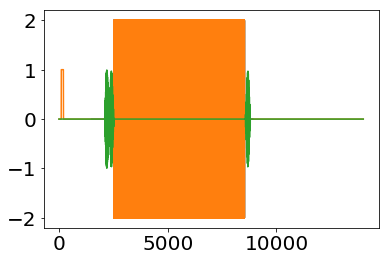

In [114]:
plt.plot(arange(len(w[0][100]))*dtsim+1500.0,w[0][100])
plt.plot(arange(len(x[4][100]))*dtsim,x[4][100])
plt.plot(arange(len(x[0][100]))*dtsim,x[0][100])
# plt.xlim(2400,2600)/

In [88]:
seq_list = [100]
output = s.psb_mesolve(experiment_name,sequences,seq_list = seq_list)
tlist,cp = s.get_charge_pulse(experiment_name,sequences)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

10.0%. Run time:  10.46s. Est. time left: 00:00:01:34
20.0%. Run time:  23.95s. Est. time left: 00:00:01:35
30.0%. Run time:  37.05s. Est. time left: 00:00:01:26
40.0%. Run time:  50.53s. Est. time left: 00:00:01:15
50.0%. Run time:  63.91s. Est. time left: 00:00:01:03
60.0%. Run time:  77.47s. Est. time left: 00:00:00:51
70.0%. Run time:  90.64s. Est. time left: 00:00:00:38
80.0%. Run time: 104.13s. Est. time left: 00:00:00:26
90.0%. Run time: 117.85s. Est. time left: 00:00:00:13
Total run time: 131.27s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:11<00:00, 131.28s/it]


Rabi frequency = 6.761887138831039 MHz 
Rabi decay time = 105863.6164561474 mus
4.527431623240006
4.527556074037375


C:\Users\slab\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


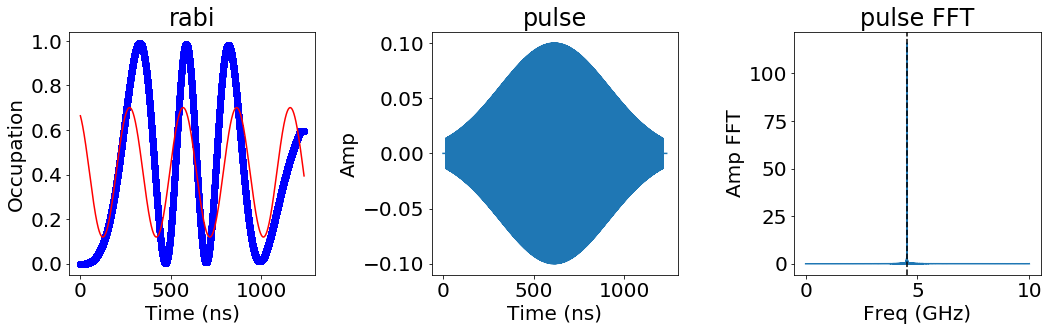

In [89]:


P = []
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131,title=experiment_name)
for ii,o in enumerate(output):
    P.append(o.expect[0])
    ax.plot(tlist, P[ii],'o-')
    fits = fitdecaysin(tlist, P[ii][:],showfit=True) 
    print ("Rabi frequency = %s MHz "%(2*fits[1]*1e3))
    print ("Rabi decay time = %s mus"%(fits[3]/1e3))
    ax.set_ylabel('Occupation')
    ax.set_xlabel('Time (ns)')


ax = fig.add_subplot(132,title='pulse')
ax.plot(tlist,cp[-3])
ax.set_ylabel('Amp')
ax.set_xlabel('Time (ns)')

ax = fig.add_subplot(133,title='pulse FFT')
f = fft.fft(cp[-1])
freq = fft.fftfreq(tlist.shape[-1])


ax.plot(freq[:int(len(f)/2)]*1/dtsim,abs(f)[:int(len(f)/2)])
print (freq[argmax(abs(f))]*1/dtsim)
print (s.find_freq(1,0,0)-s.find_freq(0,0,0))
ax.axvline((s.find_freq(1,0,0)-s.find_freq(0,0,0)),color='k',linestyle='dashed')

ax.set_ylabel('Amp FFT')
ax.set_xlabel('Freq (GHz)')
fig.tight_layout()
